In [1]:
# Butuh install jika tidak ada

# !pip install scikit-learn -q
# !pip install pandas -q

In [2]:
# === Import Library ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [3]:
# Ganti 'data.csv' dengan path file csv kamu
customers = pd.read_csv('./customers.csv')
transactions = pd.read_csv('./transactions.csv')

In [4]:
customers.head()

,customer_id,join_date
0,CUST_00001,2023-08-17
1,CUST_00002,2023-02-21
2,CUST_00003,2024-07-17
3,CUST_00004,2024-05-16
4,CUST_00005,2024-04-02


In [5]:
transactions.head()

,order_id,customer_id,order_date,package_weight,shipping_fee
0,ORD_0000001,CUST_01396,2023-05-04,1.41,10000
1,ORD_0000002,CUST_02327,2024-02-16,0.51,10000
2,ORD_0000003,CUST_02223,2023-04-19,0.18,10000
3,ORD_0000004,CUST_03809,2023-01-18,3.69,20471
4,ORD_0000005,CUST_00546,2025-03-06,0.06,10000


## Task 1: Perform clustering to group customers based on shipping behavior

In [6]:
# === 1. Data Preparation ===

# Load data
customers = pd.read_csv("customers.csv", parse_dates=["join_date"])
transactions = pd.read_csv("transactions.csv", parse_dates=["order_date"])

# Filter periode data (Jan 2023 - Des 2025)
transactions = transactions[
    (transactions["order_date"] >= "2023-01-01") & 
    (transactions["order_date"] <= "2025-12-31")
]

# Gabungkan dengan data customers agar semua customer terlihat
data = transactions.merge(customers, on="customer_id", how="left")
data.head()

,order_id,customer_id,order_date,package_weight,shipping_fee,join_date
0,ORD_0000001,CUST_01396,2023-05-04,1.41,10000,2023-11-12
1,ORD_0000002,CUST_02327,2024-02-16,0.51,10000,2024-12-29
2,ORD_0000003,CUST_02223,2023-04-19,0.18,10000,2025-12-09
3,ORD_0000004,CUST_03809,2023-01-18,3.69,20471,2024-02-16
4,ORD_0000005,CUST_00546,2025-03-06,0.06,10000,2023-04-17


In [7]:
# === 2. Feature Engineering ===

# Hitung agregasi per customer
features = (
    transactions
    .groupby("customer_id")
    .agg(
        total_orders=("order_id", "count"),
        avg_package_weight=("package_weight", "mean"),
        avg_shipping_fee=("shipping_fee", "mean"),
        active_days=("order_date", lambda x: x.dt.date.nunique())
    )
    .reset_index()
)

features.head()

,customer_id,total_orders,avg_package_weight,avg_shipping_fee,active_days
0,CUST_00001,21,4.068571,24065.904762,20
1,CUST_00002,17,4.394706,23658.176471,17
2,CUST_00003,17,2.114118,14119.235294,17
3,CUST_00004,25,2.392800,13884.000000,25
4,CUST_00005,17,2.893529,17321.941176,17


In [8]:
# === 3. Data Transformation ===

X = features.drop(columns=["customer_id"])  # hanya ambil fitur numerik

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# === 4. Clustering ===

kmeans = KMeans(n_clusters=3, random_state=42)
features["cluster"] = kmeans.fit_predict(X_scaled)

print("Hasil clustering:")
features.head()

Hasil clustering:


,customer_id,total_orders,avg_package_weight,avg_shipping_fee,active_days,cluster
0,CUST_00001,21,4.068571,24065.904762,20,1
1,CUST_00002,17,4.394706,23658.176471,17,1
2,CUST_00003,17,2.114118,14119.235294,17,0
3,CUST_00004,25,2.392800,13884.000000,25,2
4,CUST_00005,17,2.893529,17321.941176,17,0


## Task 2: Determine the optimal number of clusters and explain your method

In [10]:
# Range jumlah cluster yang akan diuji
K = range(2, 11)

silhouette_scores = []
best_score = -1
best_k = None

# Uji semua k dan simpan silhouette score
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    
    if score > best_score:
        best_score = score
        best_k = k

# Simpan cluster terbaik ke variabel
best_cluster = best_k
print(f"Cluster optimal berdasarkan Silhouette Score: {best_cluster} (score = {best_score:.4f})")

Cluster optimal berdasarkan Silhouette Score: 3 (score = 0.3505)


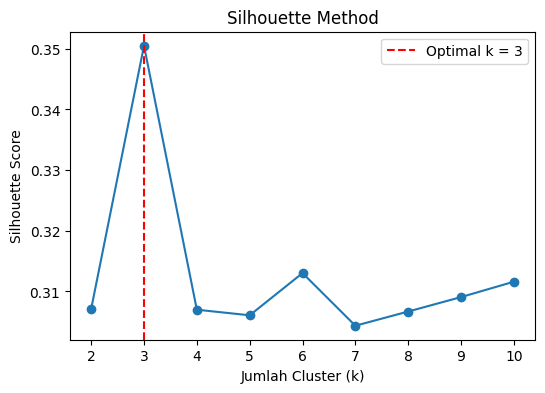

In [11]:
# --- Plot Silhouette Score ---
plt.figure(figsize=(6,4))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.axvline(best_cluster, color='r', linestyle='--', label=f'Optimal k = {best_cluster}')
plt.legend()
plt.show()

In [12]:
# --- Clustering ulang dengan jumlah cluster optimal ---
kmeans_final = KMeans(n_clusters=best_cluster, random_state=42, n_init=10)
features["cluster"] = kmeans_final.fit_predict(X_scaled)

print("Hasil clustering dengan cluster optimal:")
features.head()

Hasil clustering dengan cluster optimal:


,customer_id,total_orders,avg_package_weight,avg_shipping_fee,active_days,cluster
0,CUST_00001,21,4.068571,24065.904762,20,0
1,CUST_00002,17,4.394706,23658.176471,17,0
2,CUST_00003,17,2.114118,14119.235294,17,1
3,CUST_00004,25,2.392800,13884.000000,25,2
4,CUST_00005,17,2.893529,17321.941176,17,1


## Task 3: Interpret the cluster results and recommend marketing strategies

In [13]:
# --- Ringkasan per cluster ---
cluster_summary = features.groupby("cluster").agg({
    "total_orders": ["count", "mean", "median"],
    "avg_package_weight": ["mean", "median"],
    "avg_shipping_fee": ["mean", "median"],
    "active_days": ["mean", "median"]
}).reset_index()

print("--- Ringkasan Cluster ---")
cluster_summary

--- Ringkasan Cluster ---


cluster total_orders                   avg_package_weight            \
                 count       mean median               mean    median   
0       0         1364  18.128299   18.0           3.801288  3.691250   
1       1         1911  17.207745   18.0           2.502353  2.530625   
2       2         1725  24.573333   24.0           2.917299  2.908696   

  avg_shipping_fee               active_days         
              mean        median        mean median  
0     21307.059416  20810.516369   17.965543   18.0  
1     15593.265111  15693.100000   17.063318   17.0  
2     17371.981494  17309.240000   24.326957   24.0

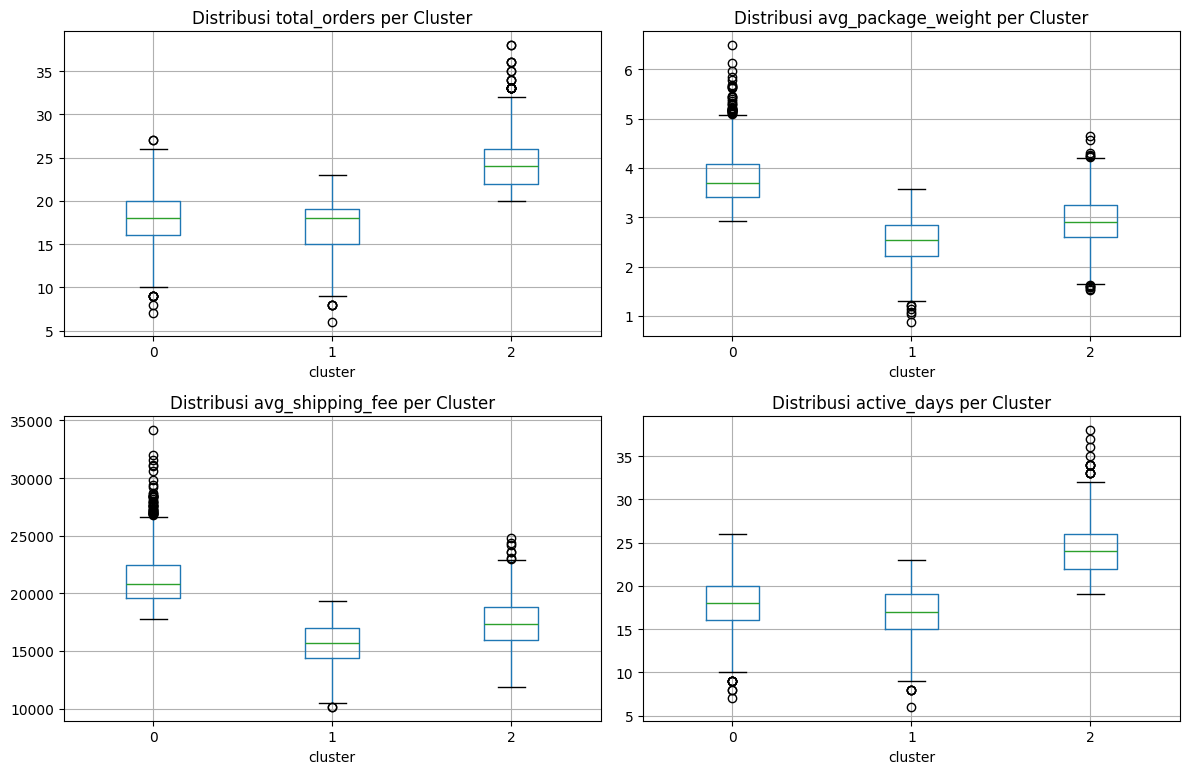

In [14]:
# --- Visualisasi distribusi fitur per cluster ---
features_for_box = ["total_orders", "avg_package_weight", "avg_shipping_fee", "active_days"]

plt.figure(figsize=(12,8))
for i, col in enumerate(features_for_box, 1):
    plt.subplot(2, 2, i)
    features.boxplot(column=col, by="cluster", ax=plt.gca())
    plt.title(f"Distribusi {col} per Cluster")
    plt.suptitle("")
plt.tight_layout()
plt.show()

In [15]:
# --- Interpretasi khusus untuk 3 cluster optimal ---
interpretations = []

for c, group in features.groupby("cluster"):
    mean_orders = group["total_orders"].mean()
    mean_weight = group["avg_package_weight"].mean()
    mean_fee = group["avg_shipping_fee"].mean()
    mean_days = group["active_days"].mean()
    
    # logika sederhana untuk 3 cluster
    if mean_orders == features.groupby("cluster")["total_orders"].mean().max():
        archetype = "High-frequency / Loyal"
        reason = "Cluster ini paling sering belanja, order mereka jauh lebih banyak dari cluster lain."
        rec = [
            "Kasih program loyalti biar makin setia.",
            "Berikan layanan ekstra kayak prioritas customer service.",
            "Coba tawarkan paket langganan."
        ]
        
    elif mean_orders == features.groupby("cluster")["total_orders"].mean().min():
        archetype = "Low-frequency / At-risk"
        reason = "Cluster ini jarang belanja, order mereka paling rendah dibanding cluster lain."
        rec = [
            "Kirim promo spesial kayak voucher atau free ongkir.",
            "Ingatkan mereka lewat notifikasi/email biar balik belanja.",
            "Bikin promo terbatas waktu biar mereka cepat action."
        ]
        
    else:
        archetype = "Mid-frequency / Growth potential"
        reason = "Cluster ini belanja lumayan sering, tapi belum setinggi pelanggan loyal. Masih bisa digarap lebih jauh."
        rec = [
            "Buat program referral supaya mereka ajak teman.",
            "Kasih promo bertahap biar makin sering belanja.",
            "Coba campaign kreatif kayak bundling produk."
        ]
    
    interpretations.append({
        "cluster": c,
        "size": len(group),
        "mean_orders": round(mean_orders,2),
        "mean_weight": round(mean_weight,2),
        "mean_fee": round(mean_fee,2),
        "mean_days": round(mean_days,2),
        "archetype": archetype,
        "reason": reason,
        "recommendations": rec
    })

interpret_df = pd.DataFrame(interpretations)
interpret_df

,cluster,size,mean_orders,mean_weight,mean_fee,mean_days,archetype,reason,recommendations
0,0,1364,18.13,3.80,21307.06,17.97,Mid-frequency / Growth potential,"Cluster ini belanja lumayan sering, tapi belum...",[Buat program referral supaya mereka ajak tema...
1,1,1911,17.21,2.50,15593.27,17.06,Low-frequency / At-risk,"Cluster ini jarang belanja, order mereka palin...",[Kirim promo spesial kayak voucher atau free o...
2,2,1725,24.57,2.92,17371.98,24.33,High-frequency / Loyal,"Cluster ini paling sering belanja, order merek...","[Kasih program loyalti biar makin setia., Beri..."


In [16]:
print("--- Interpretasi & Rekomendasi ---")
interpret_df[["cluster","archetype","reason","recommendations"]]

--- Interpretasi & Rekomendasi ---


,cluster,archetype,reason,recommendations
0,0,Mid-frequency / Growth potential,"Cluster ini belanja lumayan sering, tapi belum...",[Buat program referral supaya mereka ajak tema...
1,1,Low-frequency / At-risk,"Cluster ini jarang belanja, order mereka palin...",[Kirim promo spesial kayak voucher atau free o...
2,2,High-frequency / Loyal,"Cluster ini paling sering belanja, order merek...","[Kasih program loyalti biar makin setia., Beri..."


## Customer Segmentation Report

### Task 1: Data Preparation dan Feature Engineering
1. **Data Preparation**
   - Filter transaksi: Januari 2023 – Desember 2025.  
   - Gabungkan data `customers` dan `transactions` untuk memastikan semua pelanggan ter-cover.  

2. **Feature Engineering (per customer)**
   - `total_orders` → jumlah order dalam 6 bulan terakhir.  
   - `avg_package_weight` → rata-rata berat paket.  
   - `avg_shipping_fee` → rata-rata ongkir.  
   - `active_days` → jumlah hari unik ketika customer melakukan order.  

3. **Data Transformation**
   - Normalisasi fitur (`StandardScaler`) agar skala setara (karena ongkir ribuan, berat dalam kg, dan jumlah order berbeda skala).  

### Task 2: Menentukan Jumlah Cluster Optimal
- Uji beberapa nilai `k` (2–10) dengan **Silhouette Score**.  
- Ambil nilai **k dengan score tertinggi** sebagai cluster optimal.  
- Hasil menunjukkan **3 cluster** adalah pilihan terbaik.  

**Alasan Pemilihan Silhouette Score Untuk Menentukan Jumlah Cluster Optimal**
- Mengukur seberapa “rapat” (cohesion) cluster dan seberapa “terpisah” (separation) antar cluster.  

**Rentang Nilai Silhouette Score**
- +1 : Bagus, data benar-benar nempel ke cluster-nya dan jauh dari cluster lain.
- 0 : Data ada di batas antara dua cluster (ambigu pembagiannya).
- -1 : Buruk, data salah tempat, lebih dekat ke cluster lain dibanding cluster-nya sendiri.

### Task 3: Interpretasi Cluster dan Strategi Marketing

Setelah clustering dengan `k=3`, hasilnya terbagi menjadi 3 segmen utama.  
Berikut interpretasi dan rekomendasi strategi untuk tiap cluster:

#### 🔹 Cluster 0 – High-frequency / Loyal
- **Karakteristik**:  
  Cluster ini paling sering belanja, order mereka jauh lebih banyak dibanding cluster lain.  
- **Alasan segmentasi**:  
  Mereka adalah pelanggan inti yang kontribusinya besar pada penjualan.  
- **Strategi yang disarankan**:  
  - Kasih program loyalti biar makin setia.  
  - Berikan layanan ekstra seperti prioritas customer service.  
  - Coba tawarkan paket langganan untuk retensi jangka panjang.  

---

#### 🔹 Cluster 1 – Low-frequency / At-risk
- **Karakteristik**:  
  Cluster ini jarang belanja, order mereka paling rendah dibanding cluster lain.  
- **Alasan segmentasi**:  
  Mereka termasuk kategori rawan churn, bisa saja pindah ke kompetitor atau berhenti belanja.  
- **Strategi yang disarankan**:  
  - Kirim promo spesial seperti voucher atau free ongkir.  
  - Ingatkan mereka lewat notifikasi atau email biar balik belanja.  
  - Gunakan promo terbatas waktu biar mereka cepat ambil tindakan.  

---

#### 🔹 Cluster 2 – Mid-frequency / Growth Potential
- **Karakteristik**:  
  Cluster ini belanja lumayan sering, tapi belum setinggi pelanggan loyal.  
- **Alasan segmentasi**:  
  Mereka punya potensi besar untuk “naik kelas” jadi pelanggan loyal kalau ditangani dengan tepat.  
- **Strategi yang disarankan**:  
  - Buat program referral supaya mereka ajak teman.  
  - Kasih promo bertahap biar makin sering belanja.  
  - Coba campaign kreatif seperti bundling produk atau A/B testing marketing.  

---

## Kesimpulan
- **3 segmen utama pelanggan berhasil diidentifikasi.**  
  - **Loyal** → harus dijaga agar tetap setia.  
  - **At-risk** → perlu strategi reaktivasi.  
  - **Growth potential** → calon pelanggan loyal yang harus digarap lebih jauh.  